In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.plots import plot_convergence
from skopt.utils import use_named_args

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [7]:
# Load the dataset
df = pd.read_csv('data/dataset.csv')

# Separate features (X) and target (y)
X = df.drop(columns=['Quality'])  # Assuming 'quality' is the target
y = df['Quality']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
search_space = [
    Integer(50, 500, name='n_estimators'),  # Number of trees
    Integer(5, 50, name='max_depth'),  # Max tree depth
    Real(0.01, 0.5, name='min_samples_split')  # Min samples to split
]

In [ ]:
@use_named_args(search_space)
def objective(n_estimators, max_depth, min_samples_split):
    # Train a Random Forest with the suggested hyperparameters
    model = RandomForestRegressor(n_estimators=n_estimators, 
                                  max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  random_state=42)

    # Cross-validation to estimate performance
    mse = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    
    return mse  # We minimize this

In [10]:
# Perform Bayesian Optimization with Gaussian Processes
result = gp_minimize(
    func=objective,  # Objective function
    dimensions=search_space,  # Hyperparameter space
    acq_func="EI",  # Expected Improvement (EI) as the acquisition function
    n_calls=30,  # Number of iterations
    random_state=42
)

# Best hyperparameters
best_params = result.x
print(f"Best Hyperparameters: \n n_estimators: {best_params[0]} \n max_depth: {best_params[1]} \n min_samples_split: {best_params[2]:.3f}")

Best Hyperparameters: 
 n_estimators: 338 
 max_depth: 50 
 min_samples_split: 0.010


In [11]:
# Train model with best parameters
best_model = RandomForestRegressor(n_estimators=best_params[0], 
                                   max_depth=best_params[1], 
                                   min_samples_split=best_params[2], 
                                   random_state=42)
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Set MSE: {mse:.4f}")


Test Set MSE: 0.4452


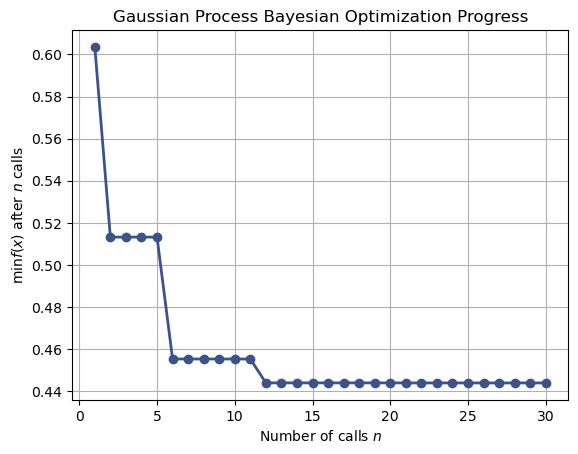

In [12]:
plot_convergence(result)
plt.title("Gaussian Process Bayesian Optimization Progress")
plt.show()


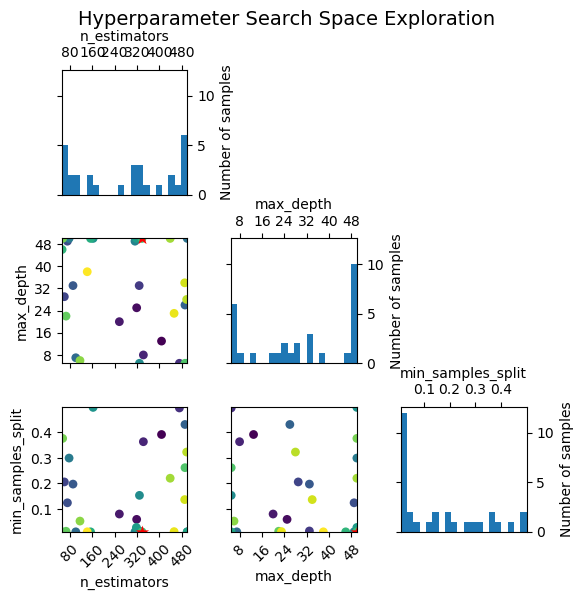

In [13]:
from skopt.plots import plot_evaluations

plot_evaluations(result)
plt.suptitle("Hyperparameter Search Space Exploration", fontsize=14)
plt.show()
